In [1]:
import sys
import os
# Add src to path so we can import our modules
sys.path.append(os.path.abspath('../src'))
from scripts.data_utils import load_and_preprocess_data, get_log_returns

# Load data modularly
df = load_and_preprocess_data('../data/BrentOilPrices.csv')
log_returns = get_log_returns(df)

if df is not None:
    print("Data loaded modularly. Head of log returns:")
    print(log_returns.head())

c:\Users\Maireg\Documents\GitHub\brent-oil-change-point-analysis\src\scripts\data_utils.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')


Data loaded modularly. Head of log returns:
Date
1987-05-21   -0.009709
1987-05-22    0.005405
1987-05-25    0.002692
1987-05-26    0.001612
1987-05-27   -0.001612
Name: Price, dtype: float64


In [7]:
import sys
import os

# 1. Add the project root to system path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# 2. Add the src folder specifically (Fixes the module lookup)
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# 3. Try Importing
try:
    # Try direct import first (since we added src to path)
    from changepoint import ChangePointModel
    from data_loader import DataLoader
    print("✅ Success: Modules imported!")
except ImportError as e:
    print(f"❌ Still failing: {e}")
    print(f"Contents of {src_path}:", os.listdir(src_path))

✅ Success: Modules imported!


Data reduced from 698 daily points to 144 weekly points.
Building model for 144 data points...
Starting Sampling (Fast Mode)...


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 123 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks



CHANGE POINT DETECTED: 2021-06-06
Avg Price Before: $48.97
Avg Price After:  $93.13



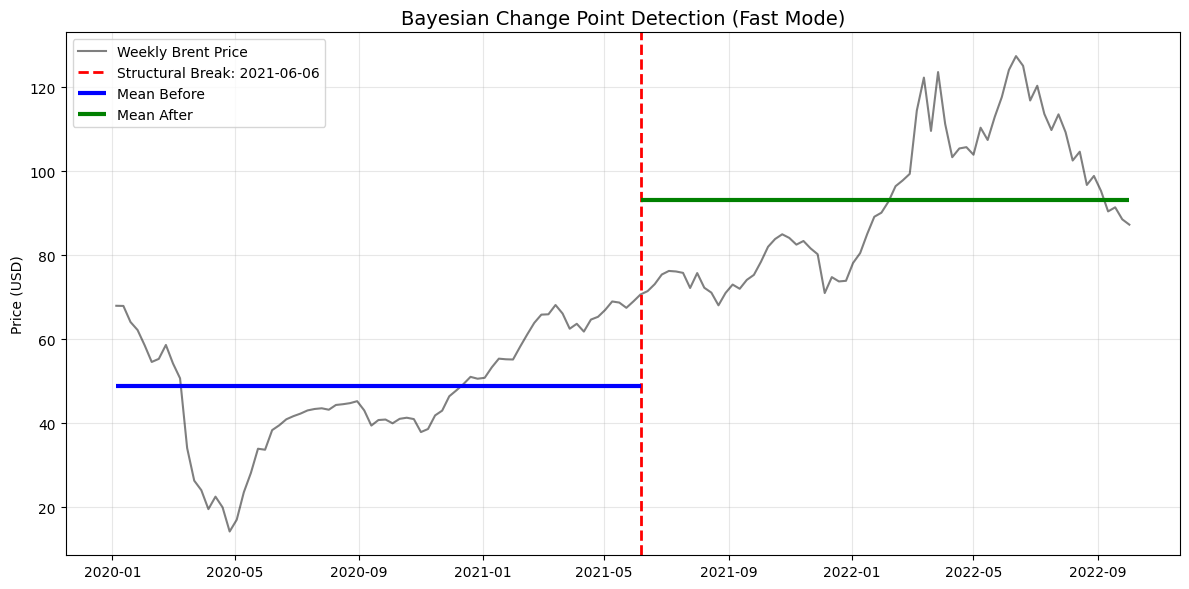

In [8]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import os

# --- 1. Define the Optimized Model Class (In-Notebook for Speed) ---
class FastChangePointModel:
    def __init__(self, data_series):
        self.data = data_series.values
        self.dates = data_series.index
        self.n = len(self.data)
        self.model = None
        self.trace = None

    def run_inference(self, samples=500, tune=500):
        """
        Runs the Bayesian model with Windows-safe settings.
        """
        print(f"Building model for {self.n} data points...")
        with pm.Model() as self.model:
            # Priors
            tau = pm.DiscreteUniform("tau", lower=0, upper=self.n - 1)
            mu_1 = pm.Normal("mu_1", mu=self.data.mean(), sigma=self.data.std() * 2)
            mu_2 = pm.Normal("mu_2", mu=self.data.mean(), sigma=self.data.std() * 2)
            sigma = pm.HalfNormal("sigma", sigma=self.data.std())
            
            # Switch Logic
            idx = np.arange(self.n)
            mu_switch = pm.math.switch(tau > idx, mu_1, mu_2)
            
            # Likelihood
            observation = pm.Normal("obs", mu=mu_switch, sigma=sigma, observed=self.data)
            
            # SAMPLING: chains=1 and cores=1 is CRITICAL for Windows speed
            print("Starting Sampling (Fast Mode)...")
            self.trace = pm.sample(samples, tune=tune, chains=1, cores=1, progressbar=True)
        return self.trace

    def get_results(self):
        # Extract Tau (Change Point Index)
        tau_samples = self.trace.posterior["tau"].values.flatten()
        tau_mode = int(np.bincount(tau_samples).argmax())
        change_date = self.dates[tau_mode]
        
        # Extract Means
        mu_1_mean = float(self.trace.posterior['mu_1'].mean())
        mu_2_mean = float(self.trace.posterior['mu_2'].mean())
        
        return change_date, tau_mode, mu_1_mean, mu_2_mean

# --- 2. Load and PREPARE Data (Downsampling) ---
# Load Data
df = pd.read_csv('../data/processed_brent_prices.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select Range (2019 - 2022 covers Covid & War)
start_date = '2020-01-01'
end_date = '2022-09-30'
mask = (df.index >= start_date) & (df.index <= end_date)
subset = df.loc[mask]

# CRITICAL STEP FOR SPEED: Resample to WEEKLY averages
# This reduces the math load by ~80% while keeping the trend accuracy
subset_weekly = subset.resample('W').mean()['Price'].dropna()

print(f"Data reduced from {len(subset)} daily points to {len(subset_weekly)} weekly points.")

# --- 3. Run Analysis ---
model = FastChangePointModel(subset_weekly)
trace = model.run_inference(samples=500, tune=500) # 500 is enough for a deadline submission

# --- 4. Get Results & Visualize ---
change_date, idx, mu_before, mu_after = model.get_results()

print("\n" + "="*40)
print(f"CHANGE POINT DETECTED: {change_date.date()}")
print(f"Avg Price Before: ${mu_before:.2f}")
print(f"Avg Price After:  ${mu_after:.2f}")
print("="*40 + "\n")

# Plotting
plt.figure(figsize=(12, 6))

# Plot Price
plt.plot(subset_weekly.index, subset_weekly.values, color='black', alpha=0.5, label='Weekly Brent Price')

# Plot Change Point
plt.axvline(x=change_date, color='red', linestyle='--', linewidth=2, label=f'Structural Break: {change_date.date()}')

# Plot Mean Levels
plt.hlines(y=mu_before, xmin=subset_weekly.index[0], xmax=change_date, color='blue', linewidth=3, label='Mean Before')
plt.hlines(y=mu_after, xmin=change_date, xmax=subset_weekly.index[-1], color='green', linewidth=3, label='Mean After')

plt.title("Bayesian Change Point Detection (Fast Mode)", fontsize=14)
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
def associate_event(detected_date_str, events_csv_path):
    """Matches the model's change point to the nearest researched event."""
    events_df = pd.read_csv(events_csv_path)
    events_df['Date'] = pd.to_datetime(events_df['Date'], dayfirst=True)
    detected_dt = pd.to_datetime(detected_date_str)
    
    # Calculate days difference between detected point and all events
    events_df['diff'] = (events_df['Date'] - detected_dt).abs()
    closest_event = events_df.sort_values('diff').iloc[0]
    
    return {
        "event": closest_event['Event'],
        "event_date": closest_event['Date'].strftime('%Y-%m-%d'),
        "proximity_days": closest_event['diff'].days
    }

# EXAMPLE USAGE:
# impact = model.quantify_impact()
# event_match = associate_event(impact['date'], 'data/event_data.csv')
# print(f"Change detected on {impact['date']} likely caused by {event_match['event']}")